In [1]:
import os
import iris
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

# Weekly Reanalysis Data - Main (reshape `xarray`)



Using the `xarray` library, let's analyze the reanalysis product

In [2]:
ds_grib = xr.load_dataset('../cdsapi_requested_files/adaptor.mars.external-1579561890.771786-7623-33-477f8046-dadc-4922-9f24-ef068afe5647.grib', 
                          engine='cfgrib')
ds_grib

<xarray.Dataset>
Dimensions:     (time: 736, values: 542080)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
Dimensions without coordinates: values
Data variables:
    t2m         (time, values) float32 247.30748 247.49889 ... 225.18036
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-01-22T09:08:10 GRIB to CDM+CF via cfgrib-0....

The GRIB file comes with a weird indexing, we have to change the numpy data array to represent position and time indexes: time, longitude, latitude. For this purpose, we need to change the index manually and reshape the data

In [3]:
index = pd.MultiIndex.from_arrays(
    [ds_grib.longitude.values, 
     ds_grib.latitude.values], 
    names=['lon', 'lat']
)
ds_grib['values'] = index
ds_grib_reshaped = ds_grib.unstack('values')

In [4]:
ds_grib_reshaped

<xarray.Dataset>
Dimensions:     (lat: 640, lon: 11942, time: 736)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (lon, lat) float64 -89.78 -89.51 -89.23 -88.95 ... nan nan nan
    longitude   (lon, lat) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
  * lon         (lon) float64 0.0 0.2812 0.2963 0.3 ... 359.7 359.7 359.7 359.7
  * lat         (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
Data variables:
    t2m         (time, lon, lat) float32 241.62193 241.77232 ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-01-22T09:08:10 GRIB to CDM+CF via cfgrib-0....

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/xarray/core/dataarray.py:1897: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


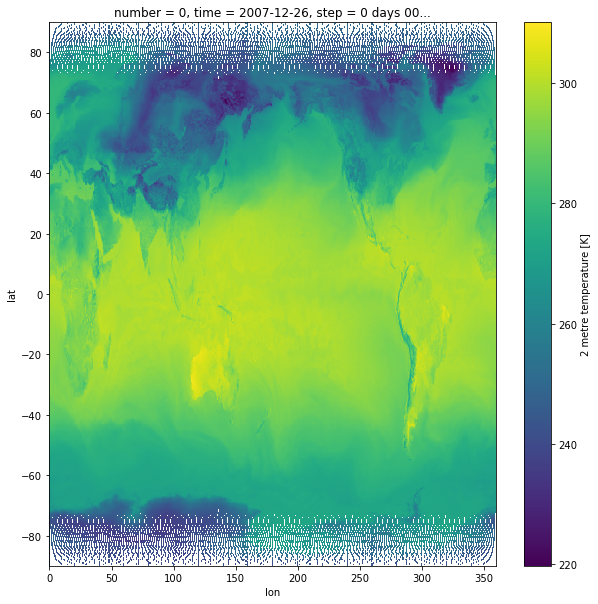

In [6]:
fig, ax = plt.subplots(figsize = (10, 10))
air = ds_grib_reshaped.t2m.T
air.isel(time=200).plot()

Resample from daily/hourly to weekly

In [7]:
air_week = air.resample(time='1W').reduce(np.mean)

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)


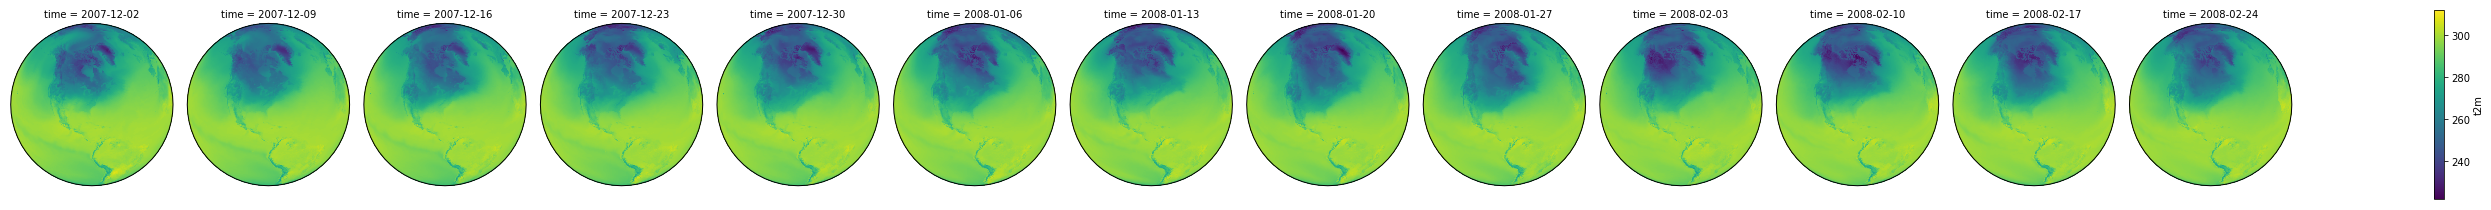

In [13]:
p = air_week.isel(time=range(0,len(air_week.time.data)-1)).plot(transform=ccrs.PlateCarree(), col='time',  
                               subplot_kws={'projection': ccrs.Orthographic(-80, 35)})

In [14]:
air_week_df = air_week.to_dataframe()

In [18]:
air_week_df = air_week_df.reset_index(drop=False).\
filter(['lat', 'lon', 'time', 't2m'])

cut_off = list(range(int(min(air_week_df.t2m)), 
           int(max(air_week_df.t2m)),
           5))

air_week_df = air_week_df.assign(temp_bracket =  pd.cut(air_week_df['t2m'], cut_off))
air_week_df_group = air_week_df.groupby(['temp_bracket', 'time'], as_index=False)['lat'].count()

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0,0.5,'Number of Reanalysis grids'), Text(0.5,0,'Temp Bracket (K)')]

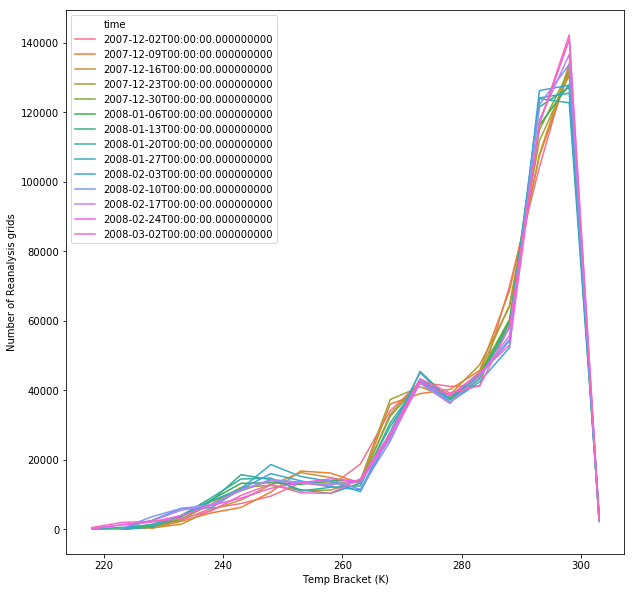

In [21]:
air_week_df_group['left_temp_interval']  = air_week_df_group.temp_bracket.apply(lambda x: x.left)

fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="lat", 
             hue='time', 
             data=air_week_df_group)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')

# Weekly Reanalysis Data - Alternative (using Pandas/No Reshape)

Using the surface temperature data from the ERA-5 European Reanalysis, we can to calculate the surface temperatures means for the northern hemishpere for a dummy winter (Dec 2007 to Mar 2008). 


In [3]:
era_5_sfc_temp = iris.load('../cdsapi_requested_files/adaptor.mars.external-1579561890.771786-7623-33-477f8046-dadc-4922-9f24-ef068afe5647.grib')
era_5_sfc_temp_array = xr.DataArray.from_iris(era_5_sfc_temp[0])

Resample data to the week level (weekly means):

In [120]:
era_5_sfc_temp_array_week = era_5_sfc_temp_array.resample(time='1W').reduce(np.mean)
era_5_sfc_temp_array_week

<xarray.DataArray 'air_temperature' (time: 14, dim_1: 542080)>
dask.array<stack, shape=(14, 542080), dtype=float64, chunksize=(1, 542080), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 2007-12-02 ... 2008-03-02
    forecast_period     timedelta64[ns] 00:00:00
    height              int64 2
    originating_centre  <U50 'European Centre for Medium Range Weather Forecasts'
    latitude            (dim_1) float64 89.78 89.78 89.78 ... -89.78 -89.78
    longitude           (dim_1) float64 0.0 20.0 40.0 60.0 ... 300.0 320.0 340.0
Dimensions without coordinates: dim_1

Transform data to `pandas` and calculate number of grids per temperature bucket (5-degrees)

In [125]:
era_5_sfc_temp_df =  era_5_sfc_temp_array_week.to_dataframe().\
reset_index(drop=False).\
filter(['latitude', 'longitude', 'time', 'air_temperature'])

In [128]:
cut_off = list(range(int(min(era_5_sfc_temp_df.air_temperature)), 
           int(max(era_5_sfc_temp_df.air_temperature)),
           5))

era_5_sfc_temp = era_5_sfc_temp_df.assign(temp_bracket =  pd.cut(era_5_sfc_temp_df['air_temperature'], cut_off))

Distribution of temperature by number of grids

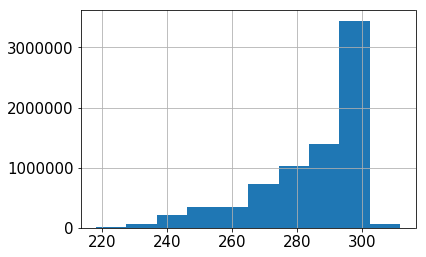

In [129]:
era_5_sfc_temp.air_temperature.hist()

In [137]:
era_5_sfc_group = era_5_sfc_temp.groupby(['temp_bracket', 'time'], as_index=False)['latitude'].count()
era_5_sfc_group['left_temp_interval']  = era_5_sfc_group.temp_bracket.apply(lambda x: x.left)

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0,0.5,'Number of Reanalysis grids'), Text(0.5,0,'Temp Bracket (K)')]

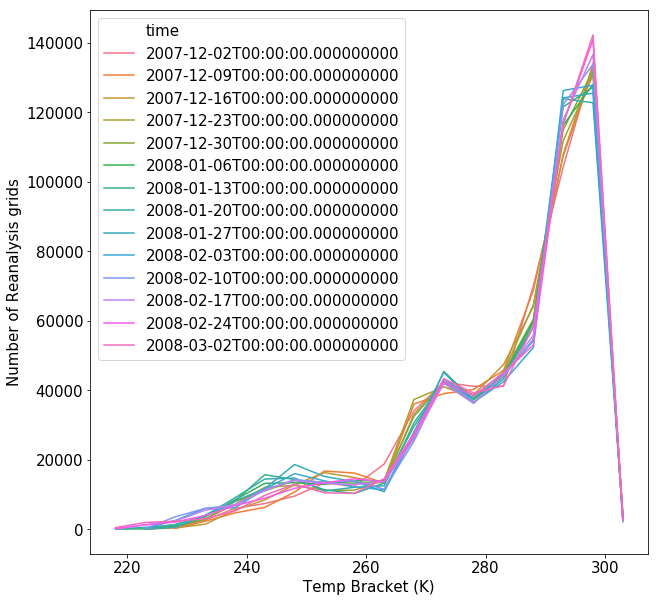

In [138]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="latitude", 
             hue='time', 
             data=era_5_sfc_group)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')

Check relatioship for northern hemisphere: all above the equator $(latitude > 0)$

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0,0.5,'Number of Reanalysis grids'), Text(0.5,0,'Temp Bracket (K)')]

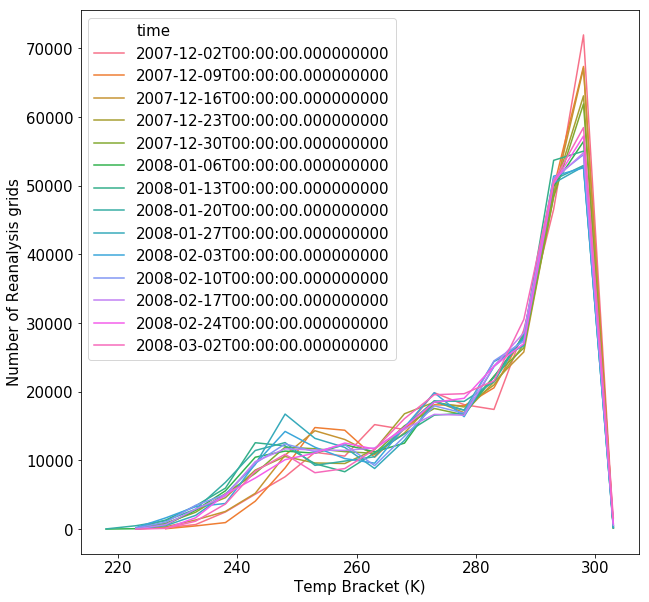

In [139]:
era_5_sfc_temp_high = era_5_sfc_temp[era_5_sfc_temp.latitude > 0]
era_5_sfc_group_high = era_5_sfc_temp_high.groupby(['temp_bracket', 'time'], as_index=False)['latitude'].count()
era_5_sfc_group_high['left_temp_interval']  = era_5_sfc_group_high.temp_bracket.apply(lambda x: x.left)

fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="latitude", 
             hue='time', 
             data=era_5_sfc_group_high)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')